In [1]:
## 기본
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import random
import time
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from quant_functions import anal_funcs, data_funcs

In [2]:
def cal_return(value, price):
    return value - price

def cal_totalReturn(realEstateReturn, stockReturn, debitCost):
    totalRturn = realEstateReturn + stockReturn - debitCost
    return totalRturn

In [3]:
dl_path = "C:/Users/GCC/git/data/temp"
## 부동산 전세 시세 ## 20231231기준
huz_ori = pd.read_csv(f"{dl_path}/시세데이터.csv")
huz_trs = huz_ori[['YYYYMMDD', 'VALUE']][(huz_ori['INDICATOR_ID'] == '매매시세(KB)')&(huz_ori['REGION_LEVEL'] == 'sd')&(huz_ori['SD'] == '서울')]
huz_trs.set_index('YYYYMMDD', inplace=True)
huz_trs.index = pd.to_datetime(huz_trs.index, format='%Y-%m-%d')

In [21]:
stock = data_funcs.get_merged_df('^IXIC', '^GSPC')

[*********************100%%**********************]  2 of 2 completed


In [57]:
stockYRR = (1+stock['^IXIC']['2004-01-01':].pct_change().mean())**252 - 1
propYRR = (1+huz_trs['VALUE'].pct_change().mean())**12-1

In [58]:
# ## 시나리오 1: 리모델링
# realEstateReturn_S1 = cal_return(14.5*1e8*1.065, 14*1e8)
# stockReturn_S1 = cal_return((11-4)*1e8*1.2, (11-4)*1e8)
# debitCost_S1 = cal_return((10)*1e8*1.04, (10)*1e8)

# totlaReturn_S1 = cal_totalReturn(realEstateReturn_S1, stockReturn_S1, debitCost_S1)

# ## 시나리오 2: 일반
# realEstateReturn_S2 = cal_return(13.5*1e8*1.065, 13.5*1e8)
# stockReturn_S2 = cal_return((11-4.1)*1e8*1.2, (11-4.1)*1e8)
# debitCost_S2 = cal_return((9.5)*1e8*1.04, (9.5)*1e8)

# totlaReturn_S2 = cal_totalReturn(realEstateReturn_S2, stockReturn_S2, debitCost_S2)

# ## 시나리오 3: 하향
# realEstateReturn_S3 = cal_return(10.7*1e8*1.065, 10.7*1e8)
# stockReturn_S3 = cal_return((11-3.21)*1e8*1.2, (11-3.21)*1e8)
# debitCost_S3 = cal_return((7.50)*1e8*1.04, (7.50)*1e8)

# totlaReturn_S3 = cal_totalReturn(realEstateReturn_S3, stockReturn_S3, debitCost_S3)

In [59]:
# minPropShare = 7*1e8
# maxPropShare = kapital/0.4

# propShare = 13.5*1e8
# debit = propShare*0.6
# stockShare = kapital - (propShare - debit)

# realEstateReturn_S3 = cal_return(propShare*1.065, propShare)
# stockReturn_S3 = cal_return(stockShare*1.2, stockShare)
# debitCost_S3 = cal_return(debit*1.04, debit)

# expectedReturn = cal_totalReturn(realEstateReturn_S3, stockReturn_S3, debitCost_S3)

In [81]:
## 항상 1차 함수
def portfolioSimulation(kapital):
    propShare = 0
    stockShare = 0
    expectedReturn = 0
    minPropShare = 0*1e8
    maxPropShare = kapital/0.4
    trace = []
    for i in np.arange(minPropShare, maxPropShare, 1e7):
        debit = i*0.75
        j = kapital - (i - debit)
        realEstateReturn = cal_return(i*(1+propYRR), i)
        stockReturn = cal_return(j*(1+stockYRR), j)
        debitCost = cal_return(debit*1.04, debit)
        totalReturn = cal_totalReturn(realEstateReturn, stockReturn, debitCost)
        trace.append([i, j, totalReturn])
        if totalReturn > expectedReturn:
            propShare = i
            stockShare = j
            expectedReturn = totalReturn
    trace = pd.DataFrame(trace, columns=['PropShare', 'StockShare', 'ExpectedReturn'])
    return propShare, stockShare, expectedReturn, trace

<Axes: xlabel='PropShare', ylabel='ExpectedReturn'>

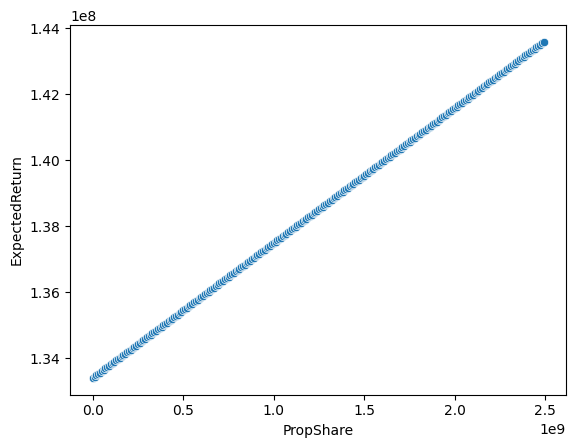

In [89]:
## property share 별 연간 기대 수익(양의 기울기일 경우에만 매입)
kapital=10*1e8
optimalPropShare, optimalStockShare, optimalExpectedReturn, trace = portfolioSimulation(kapital)
sns.scatterplot(data=trace, x='PropShare', y='ExpectedReturn')

In [90]:
## 최대 차입시 자기자본이익률
optimalExpectedReturn/kapital

0.14358936906214476

In [91]:
## stock 요구수익률
(propYRR-0.6*0.04)/(1-0.6)

0.10860375466193121

In [92]:
## property 요구수익률
0.4*stockYRR+0.6*0.04

0.07736162057627699

In [93]:
## property 최소 레버리지(expectedReturn 양수 조건)
def calMinLeverage(stockYRR, propYRR, interestRate):
    return (stockYRR-propYRR)/(stockYRR-interestRate)

calMinLeverage(stockYRR, propYRR, interestRate=0.04)

0.7062065141553666

<Axes: xlabel='PropShare', ylabel='ExpectedReturn'>

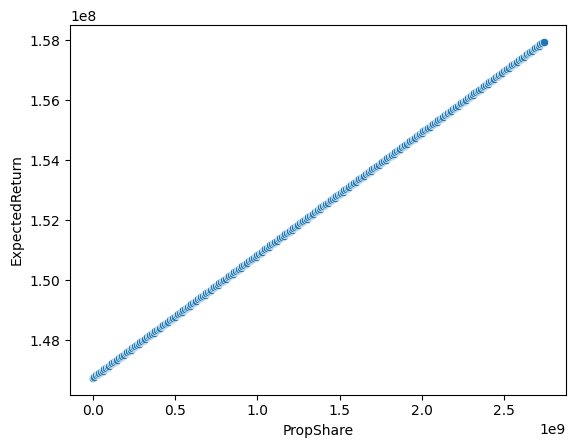